# Disease Detection On X-ray Images  
## Import library

In [19]:
# Import all the necessary libraries
import glob
import cv2
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import sparse_categorical_crossentropy

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

## Load data & augmentaion_no cv

In [2]:
train_idg = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 30,  
    zoom_range = 0.2, 
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    horizontal_flip = True,
)
test_idg = ImageDataGenerator(
    rescale = 1./255.
)
val_idg = ImageDataGenerator(
    rescale=1./255.
)

In [3]:
IMG_SIZE = (224, 224)

train = train_idg.flow_from_directory('./input/chest_xray/train', 
                                      class_mode='binary',
                                      color_mode="grayscale",
                                      target_size = IMG_SIZE
                                     )
test = test_idg.flow_from_directory('./input/chest_xray/test', 
                                    class_mode='binary',
                                    color_mode="grayscale",
                                    target_size = IMG_SIZE
                                   )
val = val_idg.flow_from_directory('./input/chest_xray/val',
                                  class_mode='binary',
                                  color_mode="grayscale",
                                  target_size = IMG_SIZE
                                 )

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
trainX, trainY = train.next()
testX, testY = test.next()
valX, valY = val.next()

print(len(trainX), len(trainY))#32 32

32 32


In [5]:
print('Train X=%s Y=%s' %(trainX.shape, trainY.shape))
print('Test X=%s Y=%s' %(testX.shape, testY.shape))
print('Val X=%s Y=%s' %(valX.shape, valY.shape))

Train X=(32, 224, 224, 1) Y=(32,)
Test X=(32, 224, 224, 1) Y=(32,)
Val X=(16, 224, 224, 1) Y=(16,)


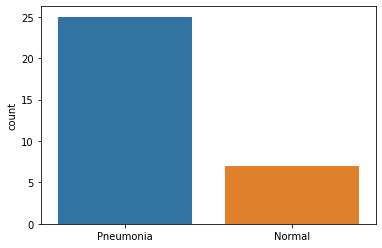

In [6]:
labels = ['Normal' if label == 0 else 'Pneumonia' for label in trainY]
sns.countplot(labels)

## Modelling_no cv

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224, 224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [17]:
history = model.fit(train ,batch_size=32, epochs = 15 , validation_data = val ,callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 [==============================] - 443s 3s/step - loss: 0.5927 - accuracy: 0.8405 - val_loss: 18.7135 - val_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 440s 3s/step - loss: 0.2902 - accuracy: 0.8984 - val_loss: 23.6093 - val_accuracy: 0.5000
Epoch 3/15
163/163 [==============================] - ETA: 0s - loss: 0.2643 - accuracy: 0.9101
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 437s 3s/step - loss: 0.2643 - accuracy: 0.9101 - val_loss: 12.6644 - val_accuracy: 0.5000
Epoch 4/15
163/163 [==============================] - 435s 3s/step - loss: 0.1712 - accuracy: 0.9471 - val_loss: 0.6836 - val_accuracy: 0.5625
Epoch 5/15
163/163 [==============================] - 434s 3s/step - loss: 0.1416 - accuracy: 0.9517 - val_loss: 29.4749 - val_accuracy: 0.5000
Epoch 6/15
163/163 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9574
Epoch 00006: ReduceL

In [18]:
print("Loss of the model is - " , model.evaluate(testX,testY)[0])
print("Accuracy of the model is - " , model.evaluate(testX,testY)[1]*100 , "%")

1/1 [==============================] - 0s 1ms/step - loss: 0.2447 - accuracy: 0.9375
Loss of the model is -  0.2447020560503006
1/1 [==============================] - 0s 1ms/step - loss: 0.2447 - accuracy: 0.9375
Accuracy of the model is -  93.75 %


# FOR CV_CNN(Disease)

In [24]:
path = './input/chest_xray/'
# define paths
train_normal_dir = path + 'train/NORMAL/'
train_pneu_dir = path + 'train/PNEUMONIA/'

test_normal_dir = path + 'test/NORMAL/'
test_pneu_dir = path + 'test/PNEUMONIA/'

val_normal_dir = path + 'val/NORMAL/'
val_pneu_dir = path + 'val/PNEUMONIA/'

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg') #1341
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')#3875

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')#234
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')#390

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')#8
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')#8


# make path using / instead of \\ ... this may be redudant step
train_normal_cases = [x.replace('\\', '/') for x in train_normal_cases]
train_pneu_cases = [x.replace('\\', '/') for x in train_pneu_cases]
test_normal_cases = [x.replace('\\', '/') for x in test_normal_cases]
test_pneu_cases = [x.replace('\\', '/') for x in test_pneu_cases]
val_normal_cases = [x.replace('\\', '/') for x in val_normal_cases]
val_pneu_cases = [x.replace('\\', '/') for x in val_pneu_cases]

In [25]:
# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, 0])

for x in train_pneu_cases:
    train_list.append([x, 1])

for x in test_normal_cases:
    test_list.append([x, 0])

for x in test_pneu_cases:
    test_list.append([x, 1])

for x in val_normal_cases:
    val_list.append([x, 0])

for x in val_pneu_cases:
    val_list.append([x, 1])

In [26]:
# shuffle/randomize data as they were loaded in order: normal cases, then pneumonia cases
random.shuffle(train_list)
random.shuffle(test_list)
random.shuffle(val_list)

In [27]:
# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])
val_df = pd.DataFrame(val_list, columns=['image', 'label'])

## Visualize distribution of cases_cv

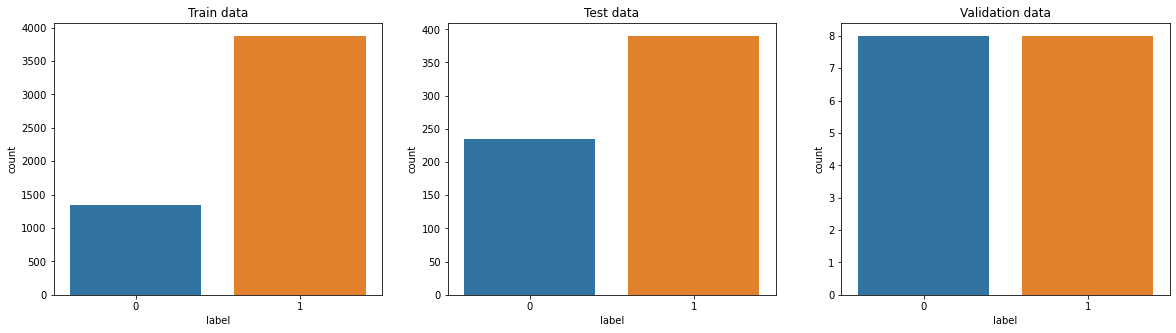

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['label'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['label'])
plt.title('Validation data')

plt.show()

**여기서 class_weight 조절의 필요성을 생각해볼 필요가 있음.. 
**학습 데이터를 보면 정상 자료가 비정상 환자 자료에 비에 부족한 편  
**딥러닝에서 클래스 불균형을 다루는 방법  

현실 데이터에는 클래스 불균형 (class imbalance) 문제가 자주 있다.   
어떤 데이터에서 각 클래스 (주로 범주형 반응 변수) 가 갖고 있는 데이터의 양에 차이가 큰 경우,   
"현실 데이터" 에 클래스 불균형 문제가 있다고 말한다.  

- 더욱 큰 비중 (weight) 를 두고 정확한 예측을 할 수 있도록 만들어야한다.  
- 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 하는 방법  
- 정상환자 클래스의 데이터에 관해서는 loss 가 더 크도록 만드는 것이다.  

## Data preprocessing_cv  

process_data - 이미지 로드, 크기 조정, 그레이스케일로 변환, 정규화 및 텐서 흐름에 필요한 차원으로 재조정  
compose_dataset - 이미지를 반복하여 2 Numpy 배열 생성. 첫째는 이미지 자체를 매트릭스로 포함하며, 둘째는 레이블을 포함함

In [29]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (224, 224,1))
   
    return img

def compose_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
       
    return np.array(data), np.array(labels)

In [30]:
X_train, y_train = compose_dataset(train_df)
X_test, y_test = compose_dataset(test_df)
X_val, y_val = compose_dataset(val_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


### Weight decay
가중치 감소는 학습 중에 가중치가 큰 것에 대해서는 일종의 패널티를 부과해 과적합의 위험을 줄이는 방법이다. 가중치의 제곱 법칙(L2 법칙; 많이 사용된다)를 손실함수에 더해 손실함수 값이 더 커지게 한다. 그만큼 가중치가 커지는 것을 억제하기 되는 것이다.



L2 법칙은 1/2곱하기 λ(람다) 곱하기 W제곱 이다.

람다는 정규화의 세기를 조절하는 하이퍼파라미터이다.

람다를 크게 설정할수록 가중치에 대한 페널티가 커진다. 


출처: https://sacko.tistory.com/45 [데이터 분석하는 문과생, 싸코]

In [31]:
weights = compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 1.9448173005219984, 1: 0.6730322580645162}


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [32]:
weights = compute_class_weight('balanced', np.unique(y_test), y_test)
weights = {0: weights[0], 1: weights[1]}
print(weights)

{0: 1.3333333333333333, 1: 0.8}


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1
 1 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1
 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0
 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0
 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1
 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1
 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 1
 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0
 0 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 1 0 0 0 1 0 0
 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 0
 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1

In [33]:
weights = compute_class_weight('balanced', np.unique(y_va), y_val)
weights = {0: weights[0], 1: weights[1]}
print(weights)


NameError: name 'y_va' is not defined

## Data augmentation_CV

In [ ]:
# define generator
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## Kfold  Cross Validation

In [ ]:
kfold = KFold(n_splits=5, shuffle=True)

# Model configuration
img_width, img_height, img_num_channels = 224, 224, 1 #gray image channel = 1
loss_function = sparse_categorical_crossentropy
acc_per_fold = []
loss_per_fold = []

## Modeling_CV(Disease)

In [12]:
def get_model():
    model = Sequential([
        Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (224, 224,1)),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        
        Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.1),
        BatchNormalization(),
        
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        BatchNormalization(),
        
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.2),
        BatchNormalization(),
        
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.2),
        BatchNormalization(),
        
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Flatten(),
        Dense(units = 128 , activation = 'relu'),
        Dropout(0.2),
        Dense(units = 2 , activation = 'sigmoid')##2 or 1 + sigmoid or softmax       
    ])
    # compile model model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
   
    ## 최적화 adam or rmsprop..
    # compile model
    optimizer = Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [13]:
for i, (train, test) in enumerate(kfold.split(X_train, y_train), 1):
   
    print(f'training model for Kfold #{i}')
    callback = EarlyStopping(monitor='loss', patience=6)
   
    model = get_model()

    # Fit data to model
    #model.fit(datagen.flow(X_train[train], y_train[train], batch_size=4),
    history = model.fit(X_train[train], y_train[train],
                        validation_data=(X_train[test], y_train[test]),
                        batch_size = 16,
                        epochs=20,
                        callbacks=[callback],
                        verbose = 1,
                        class_weight={0:6.0, 1:0.5}
                       )
   
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'Score for fold {i}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
   
    filename = './models/model_Diseasecnn' + str(i) + '.h5'
    model.save(filename)
    print('>Saved %s' % filename)

training model for Kfold #1
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
261/261 [==============================] - 352s 1s/step - loss: 0.8508 - accuracy: 0.8034 - val_loss: 5.1243 - val_accuracy: 0.7500
Epoch 2/20
261/261 [==============================] - 364s 1s/step - loss: 0.2225 - accuracy: 0.9252 - val_loss: 1.3726 - val_accuracy: 0.7711
Epoch 3/20
261/261 [==============================] - 374s 1s/step - loss: 0.1334 - accuracy: 0.9540 - val_loss: 0.1204 - val_accuracy: 0.9598
Epoch 4/20
261/261 [==============================] - 344s 1s/step - loss: 0.0930 - accuracy: 0.9618 - val_loss: 0.0992 - val_accuracy: 0.9617
Epoch 5/20
261/261 [==============================] - 343s 1s/step - loss: 0.0934 - accuracy: 0.9610 - val_loss: 0.0640 - val_accuracy: 0.9799
Epoch 6/20
261/261 [==============================] - 344s 1s/step - loss: 0.0527 - accuracy: 0.9763 - val_loss: 0.0904

261/261 [==============================] - 347s 1s/step - loss: 0.0550 - accuracy: 0.9819 - val_loss: 0.1844 - val_accuracy: 0.9482
Epoch 16/20
261/261 [==============================] - 340s 1s/step - loss: 0.1801 - accuracy: 0.9515 - val_loss: 0.1261 - val_accuracy: 0.9664
Epoch 17/20
261/261 [==============================] - 340s 1s/step - loss: 0.1490 - accuracy: 0.9639 - val_loss: 0.0957 - val_accuracy: 0.9712
Epoch 18/20
261/261 [==============================] - 376s 1s/step - loss: 0.0303 - accuracy: 0.9865 - val_loss: 0.0965 - val_accuracy: 0.9770
Epoch 19/20
261/261 [==============================] - 380s 1s/step - loss: 0.0153 - accuracy: 0.9937 - val_loss: 0.0695 - val_accuracy: 0.9837
Epoch 20/20
261/261 [==============================] - 403s 2s/step - loss: 0.0079 - accuracy: 0.9955 - val_loss: 0.0807 - val_accuracy: 0.9770
Score for fold 3: loss of 0.08070738613605499; accuracy of 97.69894480705261%
>Saved ./models/model_Diseasecnn3.h5
training model for Kfold #4
Epoch

In [14]:
# == Provide average scores ==
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.0907655730843544 - Accuracy: 97.5095808506012%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.45014071464539 (+- 0.8610083275046639)
> Loss: 0.10398115292191505
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 0.1059173047542572 - Accuracy: 97.41131067276001%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 97.45014071464539 (+- 0.8610083275046639)
> Loss: 0.10398115292191505
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 0.08070738613605499 - Accuracy: 97.69894480705261%
-------------------------------------------------

In [47]:
acc_per_fold

[95.4023003578186,
 94.8226273059845,
 94.15148496627808,
 97.7948248386383,
 88.20709586143494]

In [15]:
def avg(list):
    return (sum(list)/len(list))

print("Test loss  : {}".format(avg(loss_per_fold)))
print("Test accuracy : {}".format(avg(acc_per_fold)))

Test loss  : 0.10398115292191505
Test accuracy : 97.45014071464539


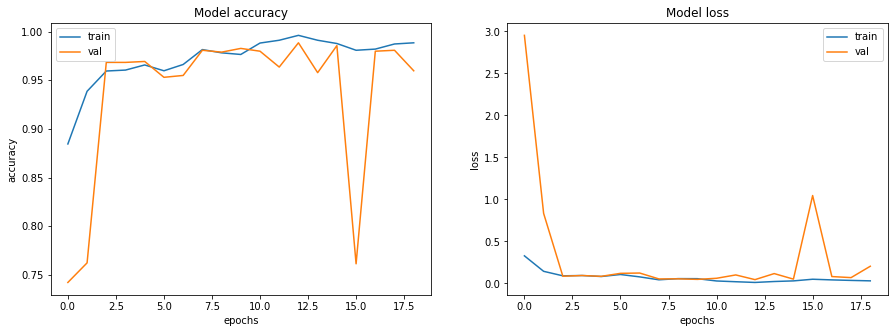

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])